In [1]:
import json
import glob
import os
import pandas as pd
import numpy as np
from collections import defaultdict

In [2]:
def mkdirp(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [3]:
df = pd.DataFrame()

for implementation in ["python", "java"]:
    for run_path in glob.glob("./microbench_" + implementation + "*"):
        if not os.path.isdir(run_path):
            continue
        run = os.path.basename(run_path)
        
        for sample_path in glob.glob(run_path + "/output/*"):
            if not os.path.isdir(sample_path):
                continue
            sample = os.path.basename(sample_path)
            
            sample_df = pd.read_csv(sample_path + "/runtime.csv", index_col=0, header=0)
            sample_df = sample_df.rename(columns={ "Runtime (s)": run })
            df = df.add(sample_df, fill_value=0)
            

for run_path in glob.glob("./microbench_cxx_*"):
    if not os.path.isdir(run_path):
            continue
    run = os.path.basename(run_path)

    for sample_path in glob.glob(run_path + "/output-docker/*"):
        if not os.path.isdir(sample_path):
            continue
        sample = os.path.basename(sample_path)
        if sample == "attachments":
            continue

        json_data = None
        with open(sample_path + "/runtimes/runtimes.json", "r") as f:
            json_data = json.load(f)
        json_data = json_data["misaxx-microbenchmark:attachments/microbench-runtimes"]["data"]

        index = []
        value = []
        for key in json_data.keys():
            index.append(key)
            value.append(json_data[key])
        sample_df = pd.DataFrame({ run: value }, index=index)
        df = df.add(sample_df, fill_value=0)

In [4]:
df

microbench_cxx_misaxx_nooptMT  microbench_cxx_misaxx_optMT  \
canny                            6.683938                     3.734827   
fft-ifft                        45.904145                    49.057159   
io                             196.922822                   166.412490   
median                          14.091733                    13.939925   
morphology                      45.344820                    45.316373   
otsu                             2.670687                     3.149024   
percentile                      33.368072                    33.259937   
wiener2                         17.155706                    22.248411   

            microbench_java_imglib2_nooptMT  \
canny                              3374.880   
fft-ifft                             16.567   
io                                  834.830   
median                              503.814   
morphology                          179.143   
otsu                                 71.656   
percentile                          222.344   
wiener2                             322.247   

            microbench_python_snakemake_nooptMT  \
canny                                210.488985   
fft-ifft                             177.803395   
io                                    25.848787   
median                               114.988077   
morphology                           471.310603   
otsu                                  13.174629   
percentile                             8.379232   
wiener2                               37.463800   

            microbench_python_snakemake_optMT  
canny                              213.270695  
fft-ifft                           178.897030  
io                                  35.619057  
median                             113.514382  
morphology                         472.375679  
otsu                                13.073366  
percentile                           8.483529  
wiener2                             38.328999

In [6]:
mkdirp("analysis/microbench")
df.to_csv("analysis/microbench/summary.csv")

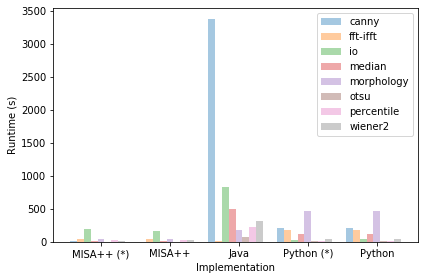

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ngroups = len(df.columns)
index = np.arange(ngroups)
bar_width = 0.1

opacity = 0.4
error_config = {'ecolor': '0.3'}

for i in range(len(df.index)):
    values = list(df.iloc[i,:])
    plt.bar(index + i * bar_width, 
            values, 
            bar_width,
            alpha=opacity,
            label=df.index[i])

plt.xlabel('Implementation')
plt.ylabel('Runtime (s)')
plt.xticks(index + len(df.index) * bar_width / 2, ["MISA++ (*)", "MISA++", "Java", "Python (*)", "Python"])
plt.legend()

plt.tight_layout()
plt.show()


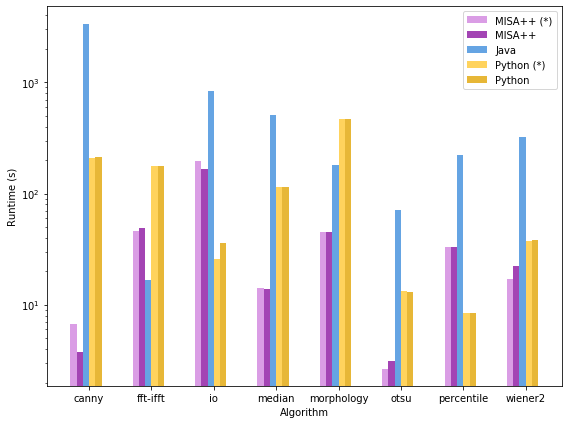

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))

ngroups = len(df.index)
index = np.arange(ngroups)
bar_width = 0.1
bar_spacing = 1

opacity = 1
error_config = {'ecolor': '0.3'}
column_names = ["MISA++ (*)", "MISA++", "Java", "Python (*)", "Python"]
colors = ["#DA9DE5", "#a344b4", "#65a4e3", "#ffd35d", "#E7B737"]

for i in range(len(df.columns)):
    values = list(df.iloc[:,i])
    plt.bar(index * bar_spacing + i * bar_width, 
            values, 
            bar_width,
            alpha=opacity,
            label=column_names[i],
            color=colors[i])

plt.xlabel('Algorithm')
plt.ylabel('Runtime (s)')
plt.xticks(index * bar_spacing + len(df.columns) * bar_width / 2, list(df.index))
plt.legend()
plt.yscale("log")

plt.tight_layout()
plt.savefig("analysis/microbench/microbench_results.svg")
plt.savefig("analysis/runtime/runtime_microbench.svg")
plt.show()
